### load necessary modules

In [2]:
import uproot
import awkward as ak
import vector
vector.register_awkward()
from matplotlib import pyplot as plt
import mplhep as hep
hep.style.use("CMS")
import math
import itertools
import os
from typing import Dict, List, Tuple
from numpy.typing import ArrayLike
import numpy as np
import correctionlib
import awkward as ak
import fastjet
import coffea
from coffea.nanoevents.methods import vector
from coffea import nanoevents
from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea.analysis_tools import Weights, PackedSelection
from hist import Hist
ak.behavior.update(vector.behavior)

In [3]:
print(coffea.__version__, coffea.__file__)
print(ak.__version__, ak.__file__)
print(uproot.__version__, uproot.__file__)

0.7.22 /Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/coffea/__init__.py
1.10.5 /Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/awkward/__init__.py
4.3.7 /Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/uproot/__init__.py


In [4]:
%load_ext autoreload
%autoreload 2

### Load signal NanoAOD files and do pre-selection 

In [5]:
! ls ../rootfiles/HWW/PKU

MERGED.root


In [6]:
# # #first way to load root file is using nanoevents, but suffer from low process speed
events = nanoevents.NanoEventsFactory.from_root(
    "../rootfiles/HWW/PKU/MERGED.root",
    schemaclass=nanoevents.NanoAODSchema,
).events()

In [7]:
# if frac==1 will use all the events
frac = 1
n_use = int(frac*len(events))
events = events[:n_use]

In [8]:
desired_fields = ["Electron","Muon","FatJet","genWeight","GenPart","FatJetPFCands","PFCands"]
filtered_events = events[desired_fields]
del events

In [9]:
filtered_events

<Array [{Electron: [Electron], ... ] type='538999 * {"Electron": var * electron,...'>

### Define necessary functions to run the selection

In [10]:
def build_p4(cand):
    return ak.zip(
        {
            "pt": cand.pt,
            "eta": cand.eta,
            "phi": cand.phi,
            "mass": cand.mass,
            "charge": cand.charge,
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )

#pad array with given value
def pad_val(
    arr: ak.Array,
    target: int,
    value: float, #value can also be Bool variable 
    axis: int = 0,
    to_numpy: bool = True,
    clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    padded_arr = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=axis)
    # pad_none will fill the array to target length with "None" for dedicated axis
    # "clip" means cut the array to the target length or not
    # fill_none will replace "None" value to some value
    return padded_arr.to_numpy() if to_numpy else padded_arr

def add_selection(
    name: str,
    sel: np.ndarray,
    selection: PackedSelection,
    cutflow: dict = None,
    isData: bool = False,
    signGenWeights: ak.Array = None,
):
    """adds selection to PackedSelection object and the cutflow dictionary"""
    selection.add(name, sel)
    if cutflow is not None: #only add to cutflow dictionary if cutflow is not None
        cutflow[name] = (
            np.sum(selection.all(*selection.names))
            if isData
            # add up sign of genWeights for MC
            else np.sum(signGenWeights[selection.all(*selection.names)])
        )

In [11]:
from typing import Dict, Tuple, Union
from coffea.nanoevents.methods.nanoaod import FatJetArray, GenParticleArray

d_PDGID = 1
c_PDGID = 4
b_PDGID = 5
g_PDGID = 21
TOP_PDGID = 6

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

GAMMA_PDGID = 22
Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25

PI_PDGID = 211
PO_PDGID = 221
PP_PDGID = 111

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

FILL_NONE_VALUE = -99999

JET_DR = 0.8

def to_label(array: ak.Array) -> ak.Array:
    return ak.values_astype(array, np.int32)

def get_pid_mask(
    genparts: GenParticleArray,
    pdgids: Union[int, list],
    ax: int = 2,
    byall: bool = True,
) -> ak.Array:
    """
    Get selection mask for gen particles matching any of the pdgIds in ``pdgids``.
    If ``byall``, checks all particles along axis ``ax`` match.
    """
    gen_pdgids = abs(genparts.pdgId)

    if type(pdgids) is list:
        mask = gen_pdgids == pdgids[0]
        for pdgid in pdgids[1:]:
            mask = mask | (gen_pdgids == pdgid)
    else:
        mask = gen_pdgids == pdgids

    return ak.all(mask, axis=ax) if byall else mask


def match_H(genparts: GenParticleArray, fatjet: FatJetArray):
    """Gen matching for Higgs samples"""
    higgs = genparts[get_pid_mask(genparts, HIGGS_PDGID, byall=False) * genparts.hasFlags(GEN_FLAGS)]

    # only select events that match an specific decay
    # matched_higgs = higgs[ak.argmin(fatjet.delta_r(higgs), axis=1, keepdims=True)][:, 0]
    matched_higgs = higgs[ak.argmin(fatjet.delta_r(higgs), axis=1, keepdims=True)]
    matched_higgs_mask = ak.any(fatjet.delta_r(matched_higgs) < 0.8, axis=1)

    matched_higgs = ak.firsts(matched_higgs)

    matched_higgs_children = matched_higgs.children
    higgs_children = higgs.children

    children_mask = get_pid_mask(matched_higgs_children, [W_PDGID], byall=False)
    is_hww = ak.any(children_mask, axis=1)

    # order by mass, select lower mass child as V* and higher as V
    matched_higgs_children = matched_higgs_children[children_mask]
    children_mass = matched_higgs_children.mass
    v_star = ak.firsts(matched_higgs_children[ak.argmin(children_mass, axis=1, keepdims=True)])
    v = ak.firsts(matched_higgs_children[ak.argmax(children_mass, axis=1, keepdims=True)])

    # VV daughters
    # requires coffea-0.7.21
    all_daus = higgs_children.distinctChildrenDeep
    all_daus = ak.flatten(all_daus, axis=2)
    all_daus_flat = ak.flatten(all_daus, axis=2)
    all_daus_flat_pdgId = abs(all_daus_flat.pdgId)

    # the following tells you about the decay
    num_quarks = ak.sum(all_daus_flat_pdgId <= b_PDGID, axis=1)
    num_leptons = ak.sum(
        (all_daus_flat_pdgId == ELE_PDGID) | (all_daus_flat_pdgId == MU_PDGID) | (all_daus_flat_pdgId == TAU_PDGID),
        axis=1,
    )
    num_electrons = ak.sum(all_daus_flat_pdgId == ELE_PDGID, axis=1)
    num_muons = ak.sum(all_daus_flat_pdgId == MU_PDGID, axis=1)
    num_taus = ak.sum(all_daus_flat_pdgId == TAU_PDGID, axis=1)

    # the following tells you about the matching
    # prongs except neutrino
    neutrinos = (
        (all_daus_flat_pdgId == vELE_PDGID) | (all_daus_flat_pdgId == vMU_PDGID) | (all_daus_flat_pdgId == vTAU_PDGID)
    )
    
    leptons = (all_daus_flat_pdgId == ELE_PDGID) | (all_daus_flat_pdgId == MU_PDGID) | (all_daus_flat_pdgId == TAU_PDGID)

    
    # num_m: number of matched leptons
    # number of quarks excludes neutrino and leptons
    num_m_quarks = ak.sum(fatjet.delta_r(all_daus_flat[~neutrinos & ~leptons]) < JET_DR, axis=1)
    num_m_leptons = ak.sum(fatjet.delta_r(all_daus_flat[leptons]) < JET_DR, axis=1)
    num_m_cquarks = ak.sum(fatjet.delta_r(all_daus_flat[all_daus_flat.pdgId == b_PDGID]) < JET_DR, axis=1)

    lep_daughters = all_daus_flat[leptons]
    # parent = ak.firsts(lep_daughters[fatjet.delta_r(lep_daughters) < JET_DR].distinctParent)
    parent = ak.firsts(lep_daughters.distinctParent)
    iswlepton = parent.mass == v.mass
    iswstarlepton = parent.mass == v_star.mass

    genVars = {"fj_genH_pt": ak.fill_none(higgs.pt, FILL_NONE_VALUE)}

    genVVars = {
        "fj_genH_jet": fatjet.delta_r(higgs[:, 0]),
        "fj_genV_dR": fatjet.delta_r(v),
        "fj_genVstar": fatjet.delta_r(v_star),
        "genV_genVstar_dR": v.delta_r(v_star),
    }
    
    genHVVVars = {
        "fj_isHVV": is_hww,
        "fj_isHVV_Matched": matched_higgs_mask,
        "fj_isHVV_4q": to_label((num_quarks == 4) & (num_leptons == 0)),
        "fj_isHVV_elenuqq": to_label((num_electrons == 1) & (num_quarks == 2) & (num_leptons == 1)),
        "fj_isHVV_munuqq": to_label((num_muons == 1) & (num_quarks == 2) & (num_leptons == 1)),
        "fj_isHVV_taunuqq": to_label((num_taus == 1) & (num_quarks == 2) & (num_leptons == 1)),
        "fj_isHVV_Vlepton": iswlepton,
        "fj_isHVV_Vstarlepton": iswstarlepton,
        "fj_genRes_mass": matched_higgs.mass,
        "fj_nquarks": num_m_quarks,
        "fj_ncquarks": num_m_cquarks,
        "fj_lepinprongs": num_m_leptons,
        "lep_daughters": leptons,
        "all_daus": all_daus,
    }

    lepVars = {
        "lepton_pt": all_daus_flat[leptons].pt,
        "lepton_eta": all_daus_flat[leptons].eta,
        "lepton_phi": all_daus_flat[leptons].phi,
        "lepton_mass": all_daus_flat[leptons].mass,        
    }
    
    quarkVars = {
        "quark_pt": all_daus_flat[all_daus_flat_pdgId <= b_PDGID].pt,
        "quark_eta": all_daus_flat[all_daus_flat_pdgId <= b_PDGID].eta,
        "quark_phi": all_daus_flat[all_daus_flat_pdgId <= b_PDGID].phi,
        "quark_mass": all_daus_flat[all_daus_flat_pdgId <= b_PDGID].mass,        
    }    
    
    genVars = {**genVars, **genVVars, **genHVVVars, **lepVars, **quarkVars}

    return genVars

# Apply HWWlnuqq analysis-level selection

In [12]:
isData = False
signGenWeights = None if isData else np.sign(filtered_events["genWeight"]) #get genWeight sign, because only the sign matters
n_events = len(filtered_events) if isData else int(np.sum(signGenWeights)) #events number for MC events should be the sum of "sign"
selection = PackedSelection() #initialize a new object

# define the cutflow table to debug
cutflow = {}
cutflow["all"] = n_events

########## 1. leading jet pT > 250GeV
fatjets = filtered_events.FatJet
preselection_cut_jet = np.prod(
    pad_val(
        (filtered_events.FatJet.pt > 250),
        1, #pad to num_jets length
        False,  #pad with value False
        axis=1, #pad to axis=1
    ),
    axis=1,
)

add_selection(
    "at least 1 AK8 jet with pT>250GeV", #string name
    preselection_cut_jet.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)

########## 2. one good lepton selection
muons = ak.with_field(filtered_events.Muon, 0, "flavor")
electrons = ak.with_field(filtered_events.Electron, 1, "flavor")

# OBJECT: muons
loose_muons = (
    (((muons.pt > 30) & (muons.pfRelIso04_all < 0.25)) | (muons.pt > 55))
    & (np.abs(muons.eta) < 2.4)
    & (muons.looseId)
)
n_loose_muons = ak.sum(loose_muons, axis=1)

good_muons = (
    (muons.pt > 30)
    & (np.abs(muons.eta) < 2.4)
    & (np.abs(muons.dz) < 0.1)
    & (np.abs(muons.dxy) < 0.05)
    & (muons.sip3d <= 4.0)
    & muons.mediumId
    & (((muons.pfRelIso04_all < 0.15) & (muons.pt < 55)) | (muons.pt >= 55))
)
n_good_muons = ak.sum(good_muons, axis=1)

# OBJECT: electrons
loose_electrons = (
    (((electrons.pt > 38) & (electrons.pfRelIso03_all < 0.25)) | (electrons.pt > 120))
    & (np.abs(electrons.eta) < 2.4)
    & ((np.abs(electrons.eta) < 1.44) | (np.abs(electrons.eta) > 1.57))
    & (electrons.cutBased >= electrons.LOOSE)
)
n_loose_electrons = ak.sum(loose_electrons, axis=1)

good_electrons = (
    (electrons.pt > 38)
    & (np.abs(electrons.eta) < 2.4)
    & ((np.abs(electrons.eta) < 1.44) | (np.abs(electrons.eta) > 1.57))
    & (np.abs(electrons.dz) < 0.1)
    & (np.abs(electrons.dxy) < 0.05)
    & (electrons.sip3d <= 4.0)
    & (electrons.mvaFall17V2noIso_WP90)
    & (((electrons.pfRelIso03_all < 0.15) & (electrons.pt < 120)) | (electrons.pt >= 120))
)
n_good_electrons = ak.sum(good_electrons, axis=1)

sel_mu = (n_good_muons == 1) & (n_good_electrons == 0) & (n_loose_electrons == 0) & (~ak.any(loose_muons & ~good_muons, 1))
sel_ele = (n_good_muons == 0) & (n_good_electrons == 1) & (n_loose_electrons == 0) & (~ak.any(loose_electrons & ~good_electrons, 1))

preselection_cut_lep = pad_val(
        (sel_mu | sel_ele) , #mass and pT cut of each jet in event
        len(filtered_events), #pad to num_jets length
        False,  #pad with value False
        )

add_selection(
    "lepton selection", #string name
    preselection_cut_lep.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)

########## 3. lepton inside the jet
# get candidate lepton
goodleptons = ak.concatenate([muons[good_muons], electrons[good_electrons]], axis=1)  # concat muons and electrons
goodleptons = goodleptons[ak.argsort(goodleptons.pt, ascending=False)]  # sort by pt

candidatelep = ak.firsts(goodleptons)  # pick highest pt
candidatelep_p4 = build_p4(candidatelep)  # build p4 for candidate lepton

# AK8 fatjets
fatjets = filtered_events.FatJet
fatjet_selector = (fatjets.pt > 200) & (abs(fatjets.eta) < 2.5) & fatjets.isTight
good_fatjets = fatjets[fatjet_selector]
good_fatjets = good_fatjets[ak.argsort(good_fatjets.pt, ascending=False)]  # sort them by pt

# choose candidate fatjet
fj_idx_lep = ak.argmin(good_fatjets.delta_r(candidatelep_p4), axis=1, keepdims=True)
candidatefj = ak.firsts(good_fatjets[fj_idx_lep])

lep_fj_dr = candidatefj.delta_r(candidatelep_p4)

preselection_cut_lepINjet = pad_val(
        (lep_fj_dr < 0.8) , #mass and pT cut of each jet in event
        len(filtered_events), #pad to num_jets length
        False,  #pad with value False
        )

add_selection(
    "lepton in jet selection", #string name
    preselection_cut_lepINjet.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)


########## 4. Gen-matching --> HWW jets

genVars = match_H(filtered_events.GenPart, candidatefj)

preselection_cut_hww = pad_val(
        (genVars["fj_isHVV"] == 1) , #mass and pT cut of each jet in event
        len(filtered_events), #pad to num_jets length
        False,  #pad with value False
        )
add_selection(
    "is HWW", #string name
    preselection_cut_hww.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)

########## 5. Gen-matching --> HWW Matched jets
preselection_cut_hww_matched = pad_val(
        (genVars["fj_isHVV_Matched"] == 1) , #mass and pT cut of each jet in event
        len(filtered_events), #pad to num_jets length
        False,  #pad with value False
        )
add_selection(
    "is HWW matched", #string name
    preselection_cut_hww_matched.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)

########## 6. Gen-matching --> HWWlnuqq jets
preselection_cut_hwwlnuqq = pad_val(
        ((genVars["fj_isHVV_elenuqq"] == 1) | (genVars["fj_isHVV_munuqq"] == 1)) , #mass and pT cut of each jet in event
        len(filtered_events), #pad to num_jets length
        False,  #pad with value False
        )
add_selection(
    "is HWWlnuqq", #string name
    preselection_cut_hwwlnuqq.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)

/Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/coffea/nanoevents/methods/nanoaod.py:107: UserWarning: distinctChildrenDeep may not give correct answers for all generators!
  warnings.warn(


In [13]:
cutflow

{'all': 538727,
 'at least 1 AK8 jet with pT>250GeV': 289731.0,
 'lepton selection': 37398.0,
 'lepton in jet selection': 25376.0,
 'is HWW': 25376.0,
 'is HWW matched': 25112.0,
 'is HWWlnuqq': 22024.0}

In [14]:
########## apply the selections
events_final = filtered_events[selection.all(*selection.names)]
len(events_final)

22030

### Get Gen-level info after applying the selections

In [15]:
candidatelep = ak.firsts(ak.concatenate([events_final.Muon, events_final.Electron], axis=1))  # pick highest pt
candidatelep_p4 = build_p4(candidatelep)  # build p4 for candidate lepton

# fj_idx_lep = ak.argmin(events_final.FatJet.delta_r(candidatelep_p4), axis=1, keepdims=True)
# candidatefj = ak.firsts(events_final.FatJet[fj_idx_lep])

higgs = higgs = events_final.GenPart[
    (abs(events_final.GenPart.pdgId) == HIGGS_PDGID) * events_final.GenPart.hasFlags(GEN_FLAGS)
]
HWWidx = ak.argmin(events_final.FatJet.delta_r(ak.firsts(higgs)), axis=1, keepdims=True)
candidatefj = ak.firsts(events_final.FatJet[HWWidx])

genVars = match_H(events_final.GenPart, candidatefj)

/Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/coffea/nanoevents/methods/nanoaod.py:107: UserWarning: distinctChildrenDeep may not give correct answers for all generators!
  warnings.warn(


In [16]:
genVars

{'fj_genH_pt': <Array [[299], [197], ... [652], [274]] type='22030 * var * float32[parameters={...'>,
 'fj_genH_jet': <Array [0.116, 0.265, 0.117, ... 0.0245, 0.154] type='22030 * ?float32'>,
 'fj_genV_dR': <Array [0.158, 0.379, 0.107, ... 0.0429, 0.151] type='22030 * ?float32'>,
 'fj_genVstar': <Array [0.377, 0.27, 0.166, ... 0.217, 0.176] type='22030 * ?float32'>,
 'genV_genVstar_dR': <Array [0.512, 0.408, 0.0962, ... 0.26, 0.0829] type='22030 * ?float32'>,
 'fj_isHVV': <Array [True, True, True, ... True, True, True] type='22030 * ?bool'>,
 'fj_isHVV_Matched': <Array [True, True, True, ... True, True, True] type='22030 * ?bool'>,
 'fj_isHVV_4q': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='22030 * int32'>,
 'fj_isHVV_elenuqq': <Array [0, 0, 1, 0, 0, 0, ... 1, 1, 0, 0, 0, 1] type='22030 * int32'>,
 'fj_isHVV_munuqq': <Array [1, 1, 0, 1, 1, 1, ... 0, 0, 1, 1, 1, 0] type='22030 * int32'>,
 'fj_isHVV_taunuqq': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='22030 * int32'>

### four vector for HWW jet

In [17]:
# four vector for HWW jet
higgs_jet_4vec_Hlvqq = np.array(
    np.stack((
        np.array(candidatefj.pt), 
        np.array(candidatefj.eta),
        np.array(candidatefj.phi),
        np.array(candidatefj.mass)), 
        axis=1)### four vector for HWW jet
)
higgs_jet_4vec_Hlvqq[1]

array([245.125    ,  -0.4767456,   1.4321289, 101.375    ], dtype=float32)

In [18]:
len(higgs_jet_4vec_Hlvqq)

22030

### four vector for the quarks and lepton

In [19]:
skim_vars = {
    "eta": "Eta",
    "phi": "Phi",
    "mass": "Mass",
    "pt": "Pt",
}

In [20]:
Gen2qVars = {
    f"Gen2q{var}": ak.to_numpy(
        ak.fill_none(
            ak.pad_none(genVars[f"quark_{key}"], 2, axis=1, clip=True),
            FILL_NONE_VALUE,
        )
    )
    for key, var in skim_vars.items()
}
print(len(Gen2qVars["Gen2qPt"]))

GenlepVars = {
    f"Genlep{var}": ak.to_numpy(
        ak.fill_none(
            ak.pad_none(genVars[f"lepton_{key}"], 1, axis=1, clip=True),
            FILL_NONE_VALUE,
        )
    )
    for key, var in skim_vars.items()
}

print(len(GenlepVars["GenlepPt"]))

22030
22030


In [21]:
#prepare eta, phi array only for 2q, used for Lund Plane reweighting
#since it only takes quarks gen-level 4-vector as input
eta_2q = Gen2qVars["Gen2qEta"]
phi_2q = Gen2qVars["Gen2qPhi"]
gen_parts_eta_phi_Hlvqq_2q = np.array(np.dstack((eta_2q,phi_2q)))

In [22]:
Gen2qVars["Gen2qEta"].shape

(22030, 2)

### adding the lepton

In [23]:
#prepare eta, phi array for 2q + lep, to do gen-matching of the jet
eta = np.concatenate([Gen2qVars["Gen2qEta"], GenlepVars["GenlepEta"]], axis=1)
phi = np.concatenate([Gen2qVars["Gen2qPhi"], GenlepVars["GenlepPhi"]], axis=1)

In [24]:
#count the number of quarks inside the AK8 jet, require 3 or 4 quarks.
def count_quarks_in_jets(jet_4vec, gen_parts_eta_phi, delta_r_cut=0.8):
    num_jets = len(jet_4vec)
    num_quarks_in_jets = np.zeros(num_jets, dtype=int)

    for i in range(num_jets):
        jet_eta, jet_phi = jet_4vec[i][1], jet_4vec[i][2]

        quark_eta_phi = gen_parts_eta_phi[i]
        quark_eta, quark_phi = quark_eta_phi[:, 0], quark_eta_phi[:, 1]

        delta_eta = jet_eta - quark_eta
        delta_phi = jet_phi - quark_phi

        delta_r_squared = delta_eta**2 + delta_phi**2
        quarks_in_jet = np.sqrt(delta_r_squared) < delta_r_cut

        num_quarks_in_jets[i] = np.sum(quarks_in_jet)

    return num_quarks_in_jets

gen_parts_eta_phi_HWW = np.array(np.dstack((eta,phi)))
result_lvqq = count_quarks_in_jets(higgs_jet_4vec_Hlvqq, gen_parts_eta_phi_HWW)
Hlvqq_cut = (result_lvqq >= 3)
np.sum(Hlvqq_cut)

11567

In [25]:
Hlvqq_cut

array([False, False, False, ...,  True,  True, False])

### Get FatJetPFCands 4-vector, up to 150 length to suit the input of Oz's function

In [26]:
HWW_FatJetPFCands = events_final.FatJetPFCands.jetIdx == ak.firsts(HWWidx)
HWW_FatJetPFCands_pFCandsIdx = events_final.FatJetPFCands.pFCandsIdx[HWW_FatJetPFCands]

In [27]:
HWW_FatJetPFCands_pFCandsIdx

<Array [[26, 72, 28, 76, ... 5, 46, 43, 42]] type='22030 * option[var * int32[pa...'>

In [28]:
pt_array =   ak.Array(events_final.PFCands.pt)
eta_array =  ak.Array(events_final.PFCands.eta)
phi_array =  ak.Array(events_final.PFCands.phi)
mass_array = ak.Array(events_final.PFCands.mass)

### Need to clean PFCands with dR(l,pf)<0.2

In [29]:
lep_eta = GenlepVars["GenlepEta"]
lep_phi = GenlepVars["GenlepPhi"]

In [30]:
lep_eta

array([[ 1.25      ],
       [-0.8671875 ],
       [-0.01495361],
       ...,
       [ 0.37304688],
       [-2.1953125 ],
       [-1.68359375]])

In [31]:
#this is because the length of PFCands can be up to 409, so we pad to target = 500
pf_eta = pad_val(eta_array, target = 500, axis = 1, value = 0)
pf_phi = pad_val(phi_array, target = 500, axis = 1, value = 0)
pf_pt = pad_val(pt_array, target = 500, axis = 1, value = 0)
pf_mass = pad_val(mass_array, target = 500, axis = 1, value = 0)

In [32]:
lep_eta_reshaped = lep_eta.reshape(-1,1)
lep_phi_reshaped = lep_phi.reshape(-1,1)

In [33]:
delta_eta = lep_eta_reshaped - pf_eta
delta_phi = lep_phi_reshaped - pf_phi

In [34]:
delta_r = np.sqrt(delta_eta**2 + delta_phi**2)

In [35]:
pf_eta_rm_lep = np.copy(pf_eta)
pf_phi_rm_lep = np.copy(pf_phi)
pf_pt_rm_lep = np.copy(pf_pt)
pf_mass_rm_lep = np.copy(pf_mass)

In [36]:
pf_eta_rm_lep[delta_r<0.2] = 0.0
pf_phi_rm_lep[delta_r<0.2] = 0.0
pf_pt_rm_lep[delta_r<0.2] = 0.0
pf_mass_rm_lep[delta_r<0.2] = 0.0

In [37]:
np.max(HWW_FatJetPFCands_pFCandsIdx)

467

In [38]:
selected_eta  = ak.Array(pf_eta_rm_lep)[HWW_FatJetPFCands_pFCandsIdx]
selected_phi  = ak.Array(pf_phi_rm_lep)[HWW_FatJetPFCands_pFCandsIdx]
selected_pt   = ak.Array(pf_pt_rm_lep)[HWW_FatJetPFCands_pFCandsIdx]
selected_mass = ak.Array(pf_mass_rm_lep)[HWW_FatJetPFCands_pFCandsIdx]

In [39]:
len(selected_eta[1])

61

In [40]:
# pad the selected 4-vec array up to length of 150 to match the Lund Plane input
selected_pt_padded = pad_val(selected_pt,150,0,1,True)
selected_eta_padded = pad_val(selected_eta,150,0,1,True)
selected_phi_padded = pad_val(selected_phi,150,0,1,True)
selected_mass_padded = pad_val(selected_mass,150,0,1,True)

In [41]:
pf_cands_px = selected_pt_padded * np.cos(selected_phi_padded)
pf_cands_py = selected_pt_padded * np.sin(selected_phi_padded)
pf_cands_pz = selected_pt_padded * np.sinh(selected_eta_padded)
pf_cands_E = np.sqrt(pf_cands_px**2 + pf_cands_py**2 + pf_cands_pz**2 + selected_mass_padded**2)

In [42]:
pf_cands_pxpypzE_lvqq = np.dstack((pf_cands_px,pf_cands_py,pf_cands_pz,pf_cands_E))

In [43]:
print(len(pf_cands_pxpypzE_lvqq[0]))

150


### final check the input information

In [44]:
#not all these 3 input array are without Hlvqq_cut
print(len(gen_parts_eta_phi_Hlvqq_2q))
print(len(pf_cands_pxpypzE_lvqq))
print(len(higgs_jet_4vec_Hlvqq))
print(len(candidatefj))

22030
22030
22030
22030


In [45]:
gen_parts_eta_phi_Hlvqq_2q = gen_parts_eta_phi_Hlvqq_2q[Hlvqq_cut]
pf_cands_pxpypzE_lvqq = pf_cands_pxpypzE_lvqq[Hlvqq_cut]
higgs_jet_4vec_Hlvqq = higgs_jet_4vec_Hlvqq[Hlvqq_cut]
candidatefj = candidatefj[Hlvqq_cut]

In [46]:
#not all these 3 input array are with Hlvqq_cut
print(len(gen_parts_eta_phi_Hlvqq_2q))
print(len(pf_cands_pxpypzE_lvqq))
print(len(higgs_jet_4vec_Hlvqq))
print(len(candidatefj))

11567
11567
11567
11567


# Plug in the tagger

In [47]:
def get_finetuned_score(data, model_path):
    import onnx
    import onnxruntime as ort
    import scipy

    input_dict = {
        "highlevel": data.loc[:, "inclParTMDV1_hidNeuron000":"inclParTMDV1_hidNeuron127"].values.astype("float32"),
    }

    onnx_model = onnx.load(model_path)
    onnx.checker.check_model(onnx_model)

    ort_sess = ort.InferenceSession(
        model_path,
        providers=["AzureExecutionProvider"],
    )
    outputs = ort_sess.run(None, input_dict)

    return scipy.special.softmax(outputs[0], axis=1)[:, 0]

import pandas as pd
def ak_to_pandas(output_collection: ak.Array) -> pd.DataFrame:
    output = pd.DataFrame()
    for field in ak.fields(output_collection):
        output[field] = ak.to_numpy(output_collection[field])
    return output

In [48]:
# select the hidden neurons
hids = {}
for var in candidatefj.fields:

    if "hidN" in var:
        hids[var] = candidatefj[var]

In [49]:
# put them together in a dataframe to use the function "get_finetuned_score"
data = ak_to_pandas(hids)

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_15984/3157445112.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output[field] = ak.to_numpy(output_collection[field])
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_15984/3157445112.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output[field] = ak.to_numpy(output_collection[field])
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_15984/3157445112.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

In [50]:
##################### Which tagger to use
# ParT tagger
# HWWJets_tagger_score_lvqq = candidatefj.inclParTMDV1_probHWqqWev0c + candidatefj.inclParTMDV1_probHWqqWev1c + candidatefj.inclParTMDV1_probHWqqWmv0c + candidatefj.inclParTMDV1_probHWqqWmv1c

# specify which finetuned tagger to use
# model_path = "../../weaver-core-dev/experiments_finetuning/v2_nor2/model.onnx"
model_path = "../../weaver-core-dev/experiments_finetuning/v35_12_14/model.onnx"

HWWJets_tagger_score_lvqq = get_finetuned_score(data, model_path)

In [51]:
Hlvqq_len = len(HWWJets_tagger_score_lvqq)
Hlvqq_len

11567

### Start to calculate Lund Plane weight

In [54]:
import sys, os
sys.path.insert(0, '')
sys.path.append("LundReweighting")
sys.path.append('LundReweighting/utils')
from utils.LundReweighter import *
from utils.Utils import *
""" An example how to use the Lund Plane reweighting code """

######################## Setup 


def get_tagger_SF(WP):
    #Input file 
    f_ratio_name = 'LundReweighting/data/ratio_2018.root'
    f_ratio = ROOT.TFile.Open(f_ratio_name)

    #nominal data/MC Lund plane ratio (3d histogram)
    h_ratio = f_ratio.Get("ratio_nom")
    #systematic variations
    h_ratio_sys_up = f_ratio.Get("ratio_sys_tot_up")
    h_ratio_sys_down = f_ratio.Get("ratio_sys_tot_down")
    #MC ratio of b to light quarks
    b_light_ratio = f_ratio.Get("h_bl_ratio")


    #directory of pt extrapolation fits
    f_ratio.cd('pt_extrap')
    rdir = ROOT.gDirectory #get the present working directory and give it to rdir

    #Main class for reweighting utilities
    LP_rw = LundReweighter(pt_extrap_dir = rdir)

    max_evts = len(HWWJets_tagger_score_lvqq)

    # score = getattr(d, tag_obs)[:max_evts]
    # score_cut = ((HWWJets_tagger_score_lvqq >= 0.8) & (HWWJets_tagger_score_lvqq <= 0.975))

    if len(tagger_cut)>1:
        score_cut = (HWWJets_tagger_score_lvqq > tagger_cut[0]) & (HWWJets_tagger_score_lvqq < tagger_cut[1])   
    else:
        score_cut = (HWWJets_tagger_score_lvqq > tagger_cut[0])
    score_cut = score_cut[:max_evts]


    #Number of toys for statistical and pt extrapolation uncertainties
    nToys = 100
    #Noise vectors used to to generate the toys
    #NOTE the same vector has to be used for the whole sample/signal file for the toys to be consistent 
    rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsX(), h_ratio.GetNbinsY(), h_ratio.GetNbinsZ()))
    pt_rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsY(), h_ratio.GetNbinsZ(), 3))


    ################### Compute reweighting factors

    #PF candidates in the AK8 jet
    # pf_cands = d.get_masked("jet1_PFCands").astype(np.float64)[:max_evts]
    pf_cands = pf_cands_pxpypzE_lvqq[:max_evts]
    #Generator level quarks from hard process

    # gen_parts = d.get_masked('gen_info')[:max_evts]
    gen_parts_eta_phi = gen_parts_eta_phi_Hlvqq_2q[:max_evts]
    # gen_parts_pdg_ids = gen_parts[:,:,3]

    B_PDG_ID = 5

    # ak8_jets = d.get_masked('jet_kinematics')[:max_evts][:,2:6].astype(np.float64)
    ak8_jets = higgs_jet_4vec_Hlvqq[:max_evts]

    #Nominal event weights of the MC, assume every event is weight '1' for this example
    weights_nom = np.ones(max_evts)

    LP_weights = []
    LP_weights_sys_up = []
    LP_weights_sys_down = []
    stat_smeared_weights = []
    pt_smeared_weights = []
    b_weights_up = []
    b_weights_down = []
    bad_matches = []


    for i,cands in enumerate(pf_cands):
        # if i == 4: break
        # print("now processing:",i)
        #Get the subjets, splittings and checking matching based on PF candidates in the jet and gen-level quarks
        subjets, splittings, bad_match, deltaRs = LP_rw.get_splittings_and_matching(cands, gen_parts_eta_phi[i], ak8_jets[i])
        # print(bad_match)
        # print(deltaRs)
        #Gets the nominal LP reweighting factor for this event and statistical + pt extrapolation toys
        LP_weight, stat_smeared_weight, pt_smeared_weight = LP_rw.reweight_lund_plane(h_rw = h_ratio, subjets = subjets, splittings = splittings,
                rand_noise = rand_noise, pt_rand_noise = pt_rand_noise, )
        #Now get systematic variations
        LP_weight_sys_up,_,_ = LP_rw.reweight_lund_plane(h_rw = h_ratio_sys_up, subjets = subjets, splittings = splittings)
        LP_weight_sys_down,_,_ = LP_rw.reweight_lund_plane(h_rw = h_ratio_sys_down, subjets = subjets, splittings = splittings)

        LP_weights.append(LP_weight)
        stat_smeared_weights.append(stat_smeared_weight)
        pt_smeared_weights.append(pt_smeared_weight)

        LP_weights_sys_up.append(LP_weight_sys_up)
        LP_weights_sys_down.append(LP_weight_sys_down)
        bad_matches.append(bad_match)



    ############### Normalize weights to preserve normalization of the MC sample

    #The nominal Lund Plane correction event weights
    LP_weights = LP_rw.normalize_weights(LP_weights) * weights_nom 

    #Toy variations for stat and pt uncertainties
    stat_smeared_weights = LP_rw.normalize_weights(stat_smeared_weights) * weights_nom.reshape(max_evts, 1)
    pt_smeared_weights = LP_rw.normalize_weights(pt_smeared_weights) * weights_nom.reshape(max_evts,1)

    #Systematic up/down variations
    LP_weights_sys_up = LP_rw.normalize_weights(LP_weights_sys_up) * weights_nom
    LP_weights_sys_down = LP_rw.normalize_weights(LP_weights_sys_down) * weights_nom

    ############### Compute efficiences and uncertainties


    #Efficiency of the cut in nominal MC
    eff_nom = np.average(score_cut, weights = weights_nom) #TODO

    #Efficiency of the cut after the Lund Plane reweighting
    eff_rw = np.average(score_cut, weights = LP_weights)

    #Nominal 'scale factor'
    SF = eff_rw / eff_nom

    print("Nominal efficiency %.3f, Corrected efficiency %.3f, SF (corrected / nom) %.3f" % (eff_nom, eff_rw, SF))

    #NOTE, better to use corrected efficiency computed separately for each sample rather than a single 'SF'


    #Compute efficiency for each of the stat/pt toys
    eff_toys = []
    pt_eff_toys = []
    for i in range(nToys):
        eff = np.average(score_cut, weights = stat_smeared_weights[:,i])
        eff_toys.append(eff)

        eff1 = np.average(score_cut, weights = pt_smeared_weights[:,i])
        pt_eff_toys.append(eff1)

    #Compute stat and pt uncertainty based on variation in the toys
    toys_mean = np.mean(eff_toys)
    toys_std = np.std(eff_toys)
    pt_toys_mean = np.mean(pt_eff_toys)
    pt_toys_std = np.std(pt_eff_toys)

    eff_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) 
    eff_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std)

    print("Stat variation toys eff. avg %.3f, std dev %.3f" % (toys_mean, toys_std))
    print("Pt variation toys eff. avg %.3f, std dev %.3f" % (pt_toys_mean, pt_toys_std))


    #Compute difference in efficiency due to weight variations as uncertainty
    def get_uncs(score_cut, weights_up, weights_down, eff_baseline):
        eff_up =  np.average(score_cut, weights = weights_up)
        eff_down =  np.average(score_cut, weights = weights_down)

        unc_up = eff_up - eff_baseline
        unc_down = eff_down - eff_baseline 
        return unc_up, unc_down


    #Compute efficiency of systematic variations
    sys_unc_up, sys_unc_down = get_uncs(score_cut, LP_weights_sys_up, LP_weights_sys_down, eff_rw)
    # b_unc_up, b_unc_down = get_uncs(score_cut, b_weights_up, b_weights_down, eff_rw)


    #matching uncertainty, taken as a fractional uncertainty on efficiency
    bad_match_frac = np.mean(bad_matches)
    bad_match_unc = bad_match_frac * eff_rw


    ############ Results
    print("\n\nCalibrated efficiency  is %.3f +/- %.3f  (stat) +/- %.3f (pt) +/- %.3f/%.3f (sys)+/- %.3f (matching)  \n\n"  % 
            (eff_rw, eff_stat_unc, eff_pt_unc, sys_unc_up, sys_unc_down, bad_match_unc))

    #next compute the uncertainty about SFs

    #Efficiency of the cut in nominal MC
    eff_nom = np.average(score_cut, weights = weights_nom) #TODO

    #Efficiency of the cut after the Lund Plane reweighting
    eff_rw = np.average(score_cut, weights = LP_weights)

    #Nominal 'scale factor'
    print("Now perform SFs information")
    SF = eff_rw / eff_nom

    print("SF (corrected / nom) %.3f" % (SF))

    #propagate statistical and pt extrapolation uncertainties to SF
    SF_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) /eff_nom
    SF_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std) /eff_nom

    #propagate systemetic uncertainty to SF
    eff_sys_up =  np.average(score_cut, weights = LP_weights_sys_up)
    eff_sys_down =  np.average(score_cut, weights = LP_weights_sys_down)

    sys_unc_up = abs(eff_rw - eff_sys_up)
    sys_unc_down = abs(eff_rw - eff_sys_down)

    SF_sys_unc_up = sys_unc_up/eff_nom
    SF_sys_unc_down = sys_unc_down/eff_nom

    #calculate bad matching uncertainty directly
    SF_match_unc = bad_match_frac * SF

    print("\n\nSF is %.3f +/-%.3f(stat) +/-%.5f(pt) +%.3f/-%.3f(sys) +/-%.3f(match) \n\n"  % (SF, SF_stat_unc, SF_pt_unc, sys_unc_up, sys_unc_down, SF_match_unc))
    f_ratio.Close()
    
    return LP_weights, LP_weights_sys_up, LP_weights_sys_down

In [56]:
tagger_cut = [0.75]
LP_weights, LP_weights_sys_up, LP_weights_sys_down = get_tagger_SF(tagger_cut)

Nominal efficiency 0.625, Corrected efficiency 0.589, SF (corrected / nom) 0.942
Stat variation toys eff. avg 0.588, std dev 0.011
Pt variation toys eff. avg 0.589, std dev 0.000


Calibrated efficiency  is 0.589 +/- 0.011  (stat) +/- 0.000 (pt) +/- -0.009/0.018 (sys)+/- 0.175 (matching)  


Now perform SFs information
SF (corrected / nom) 0.942


SF is 0.942 +/-0.018(stat) +/-0.00013(pt) +0.009/-0.018(sys) +/-0.280(match) 




In [69]:
len(pf_cands_pxpypzE_lvqq)

11567

In [70]:
len(HWWJets_tagger_score_lvqq)

11567

In [60]:
HWWJets_tagger_score_lvqq

array([0.9683312 , 0.56138897, 0.9818247 , ..., 0.8720592 , 0.93492466,
       0.61261135], dtype=float32)

In [61]:
LP_weights

array([0.30896689, 0.73092485, 2.71539652, ..., 0.09941369, 0.58873426,
       0.7573853 ])

In [65]:
LP_weights

array([0.30896689, 0.73092485, 2.71539652, ..., 0.09941369, 0.58873426,
       0.7573853 ])

In [64]:
LP_weights_sys_up

array([0.25325453, 0.50776321, 2.61974242, ..., 0.099898  , 0.46501632,
       0.72060035])

In [99]:
tagger_cut = [0.75, 0.88]
get_tagger_SF(tagger_cut)

Nominal efficiency 0.210, Corrected efficiency 0.208, SF (corrected / nom) 0.989
Stat variation toys eff. avg 0.209, std dev 0.005
Pt variation toys eff. avg 0.208, std dev 0.000


Calibrated efficiency  is 0.208 +/- 0.006  (stat) +/- 0.000 (pt) +/- 0.000/-0.006 (sys)+/- 0.062 (matching)  


Now perform SFs information
SF (corrected / nom) 0.989


SF is 0.989 +/-0.027(stat) +/-0.00037(pt) +0.000/-0.006(sys) +/-0.294(match) 




In [100]:
tagger_cut = [0.924]
get_tagger_SF(tagger_cut)

Nominal efficiency 0.286, Corrected efficiency 0.262, SF (corrected / nom) 0.915
Stat variation toys eff. avg 0.261, std dev 0.009
Pt variation toys eff. avg 0.262, std dev 0.000


Calibrated efficiency  is 0.262 +/- 0.010  (stat) +/- 0.000 (pt) +/- -0.011/0.021 (sys)+/- 0.078 (matching)  


Now perform SFs information
SF (corrected / nom) 0.915


SF is 0.915 +/-0.033(stat) +/-0.00028(pt) +0.011/-0.021(sys) +/-0.272(match) 




In [101]:
tagger_cut = [0.5]
get_tagger_SF(tagger_cut)

Nominal efficiency 0.808, Corrected efficiency 0.774, SF (corrected / nom) 0.958
Stat variation toys eff. avg 0.782, std dev 0.010
Pt variation toys eff. avg 0.774, std dev 0.000


Calibrated efficiency  is 0.774 +/- 0.018  (stat) +/- 0.000 (pt) +/- -0.001/0.017 (sys)+/- 0.230 (matching)  


Now perform SFs information
SF (corrected / nom) 0.958


SF is 0.958 +/-0.022(stat) +/-0.00011(pt) +0.001/-0.017(sys) +/-0.285(match) 




In [104]:
LP_weights

array([0.30896689, 0.73092485, 2.71539652, ..., 0.09941369, 0.58873426,
       0.7573853 ])

### Plot the tagger distribution about Hlvqq jet

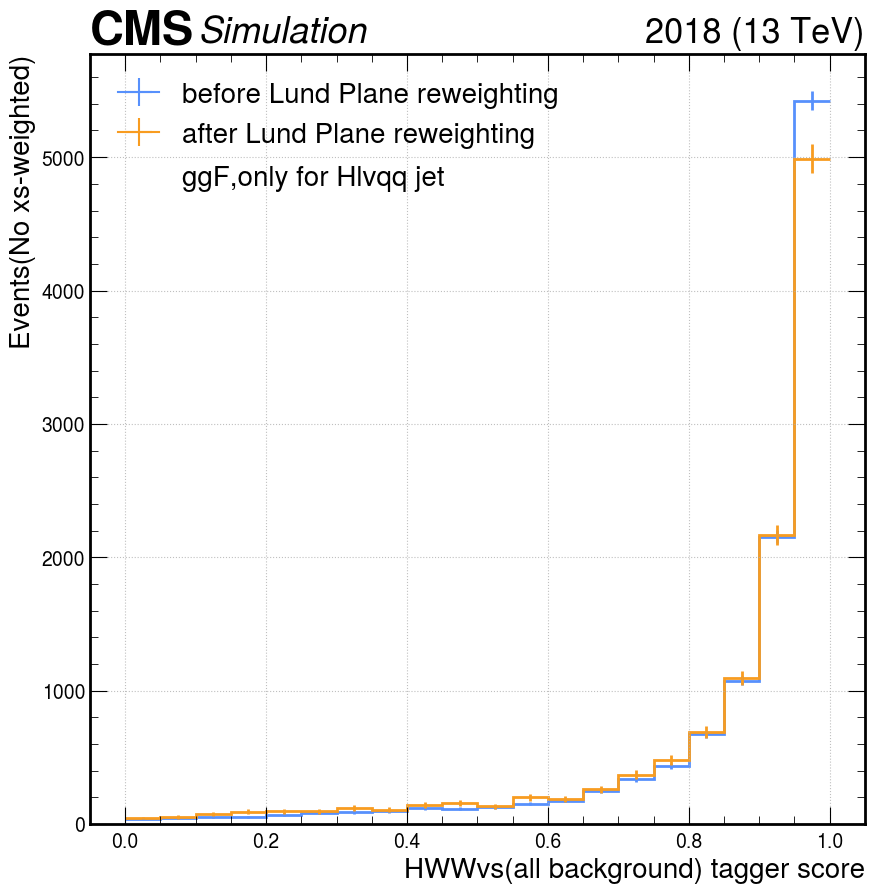

In [87]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler
max_evts = Hlvqq_len
#implement CMS plot style functions
use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

plt.figure(figsize=(10,10))
ax=plt.gca()
plt.grid()
hep.cms.label(data=False, year="2018", ax=ax, fontname='sans-serif')
%matplotlib inline
#step1: plot 

# plt.hist(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'], bins=20, range=(0,1), histtype='step', label='before reweighting',density=True);
# plt.hist(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'], bins=20, range=(0,1), histtype='step', label='after reweighting', weights=eventsEventsID3Prongs4Prongs["LP_weight"],density=True);
nbins, x_min, x_max = 20, 0, 1.0
hist_before = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hist_before.fill(HWWJets_tagger_score_lvqq[:max_evts])
hist_before_value = hist_before.view().value
hist_before_err = np.sqrt(hist_before.view().variance)

hist_after = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hist_after.fill(HWWJets_tagger_score_lvqq[:max_evts],weight=LP_weights[:max_evts])
hist_after_value = hist_after.view().value
hist_after_err = np.sqrt(hist_after.view().variance)
bins = hist_before.axes[0].edges


hep.histplot(hist_before_value,    bins=bins, yerr=hist_before_err, label= 'before Lund Plane reweighting', lw = 2,edges = False, histtype="step")
hep.histplot(hist_after_value,     bins=bins, yerr=hist_after_err,  label= 'after Lund Plane reweighting', lw = 2,edges = False, histtype="step")


plt.legend(loc='upper left',frameon=False,fontsize=20)
y_min,y_max = plt.gca().get_ylim()
plt.text(0.08, 0.83*y_max, "ggF,only for Hlvqq jet", fontsize=20)
# plt.xlabel(r'$H_{qqqq} / (H_{qqqq} + QCD + Top)$')
plt.xlabel(r'HWWvs(all background) tagger score', fontsize=20, ha='right', x=1)
plt.ylabel('Events(No xs-weighted)',fontsize=20, ha='right', y=1)
plt.savefig(f"TaggerDistribution_2018_ggF_Hlvqq_all.pdf", bbox_inches='tight')
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()